Performing inference on the test video using OpenCV DNN module as well as adding the feauture of bounding box being color according to hardhat color

In [1]:
!pip uninstall opencv-python
!pip install opencv-python==4.5.5.64


Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Gui-48e93776.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/d

In [23]:
import cv2
print(cv2.__version__)

4.5.5


In [5]:
!pip uninstall torch
!pip install torch==1.11


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 12 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.


In [6]:
import torch
print(torch.__version__)

1.11.0+cu102


In [17]:
import numpy as np
from google.colab.patches import cv2_imshow
import time

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing the onnx for convertion of .pt to .onnx.
To feed the weight into the DNN module of OpenCV, we need it to be in .onnx format

In [9]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 26.8 MB/s 


In [10]:
!pwd

/content


### Function to export .pt weights in .onnx format

In [ ]:
!python3 export.py --weights runs/train/exp/weights/best.pt --include onnx

In [11]:
# reading the .onnx weights and configuring with CPU
net = cv2.dnn.readNet('/content/drive/MyDrive/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [12]:
score_thresh = 0.2 #score threshold: to find class id with max score for each detection
nms_thresh = 0.4 #NMS threshold : to remove overlapping and duplicated detections
confidence_thresh = 0.4 #confidence threshold : how likely it is that the prediction is correct.
classes = ['helmet', 'head', 'person']

In [24]:
'''
function to resize to 640x640, normalise and swap R and B channels.
Further callling the model to produce prediction.

Input: image, model
Output: predictions in the form of 2D arrays having boundng box details for each detection
'''
def detection(image, net):
  blob = cv2.dnn.blobFromImage(image, 1/255.0, (640, 640), swapRB=True, crop=False)
  net.setInput(blob)
  prediction = net.forward() # model is called
  return prediction


In [14]:
'''
Function to return class id, confidence score and bounding box details of the prediction. 
This function unwraps the prediction array to give the above details
'''
def process_detection(input_image, output_data):
    # for storing the prediction data
    class_ids = []
    confidences = []
    boxes = []

    rows = output_data.shape[0]

    image_width, image_height, _ = input_image.shape

    x_factor = image_width / 640
    y_factor =  image_height / 640

    for r in range(rows):
        row = output_data[r]
        confidence = row[4]
        if confidence >= 0.4:  # only taking into consideration those which have confidence score greater than threshold

            classes_scores = row[5:]
            _, _, _, max_indx = cv2.minMaxLoc(classes_scores) # this function is used for finding class id with max score
            class_id = max_indx[1]
            if (classes_scores[class_id] > .25):
                # storing the data if confidence>= 0.4 and class_score>=0.25
                confidences.append(confidence)

                class_ids.append(class_id)
                
                # retrieving the bounding box details
                x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
                left = int((x - 0.5 * w) * x_factor)
                top = int((y - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left, top, width, height])
                boxes.append(box)

    # NMS to remove overlapping and duplicated predictions
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.25, 0.45) 

    result_class_ids = []
    result_confidences = []
    result_boxes = []
    
    # appending the details of final filtered prediction and reutrning them
    for i in indexes:
        result_confidences.append(confidences[i])
        result_class_ids.append(class_ids[i])
        result_boxes.append(boxes[i])

    return result_class_ids, result_confidences, result_boxes

In [15]:
'''
Function to select ROI from the bounding box region. ROI here is the 
exact region where the helmet lies.
Input : image, bounding box
Output : image of region of interest
'''
def select_ROI(img, box):
  x, y, w, l = box
  l = int(0.5 * l) # reducing the length of bounding box from bottom
  w = int(w - 0.1 * w) # slighly reducing the width of bounding box to narrow more on the ROI

  # cropping the image to obtain ROI
  roi = img[int(y + 0.5 * l):y + l, int(x + 0.1 * w):x + w] 
  return roi

'''
Function to find the most dominant color from the ROI
Input: ROI
Output: most dominant color in BGR format
'''
def most_dominant_color(roi):
  # flatten the image matrix into a array
  a2D = roi.reshape(-1,roi.shape[-1])
  # maximum possible values of rgb
  col_range = (256, 256, 256)
  # retrieves index if a 2D array is flattened.
  a1D = np.ravel_multi_index(a2D.T, col_range)
  # retrieves the most occuring combination of rgb. bincount() used for counting occurence.
  color = np.unravel_index(np.bincount(a1D).argmax(), col_range)
  b,g,r = color
  # storing the int as int64 instead of numpy.int64
  color = (b.item(),g.item(),r.item())
  return color


In [16]:
'''
Function to put the image in a square big enough
Input: image
Output : modified image
'''
def format_yolov5(frame):
    # retrieving the shape of image
    row, col, _ = frame.shape 
    # selecting bigger of width or height
    _max = max(col, row)
    # padding so as to make the square of dimensions _max
    result = np.zeros((_max, _max, 3), np.uint8)
    result[0:row, 0:col] = frame
    return result

In [21]:
capture = cv2.VideoCapture('/content/drive/MyDrive/hardhat.avi')

width= int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# object for saving the video overlayed with predictions
writer = cv2.VideoWriter('/content/drive/MyDrive/out.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))

i = 0

prev_frame_time = 0
new_frame_time = 0


while True:
  i = i + 1
  ret, frame = capture.read()
  print(i)

# if no frame return, it marks the end of video
  if frame is None:
    capture.release()
    writer.release()
    print("end")
    break
# fitting images into a padded square
  frame = format_yolov5(frame)
  # performing prediction on the image
  pred = detection(frame, net)
  # getting prediction details
  class_ids, confidences, boxes = process_detection(frame, pred[0])

# iterating through details of each prediction

  for (classid, confidence, box) in zip(class_ids, confidences, boxes):
    
    # deriving the roi of a prediction
    roi = select_ROI(frame, box)
    # getting the most significant color for the bounding box
    color = most_dominant_color(roi)
    
    # overlaying the detaild in the images
    cv2.rectangle(frame, box, color, 2)
    cv2.rectangle(frame, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)
    cv2.putText(frame, classes[classid] + ' ' + str(int(confidence*100)) + '%', (box[0], box[1] - 10), cv2.FONT_HERSHEY_DUPLEX, 0.3, (0,0,0))

    new_frame_time = time.time()

    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    fps = "FPS: %.2f" % fps

    # calculated fps 

    cv2.putText(frame, fps, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # resizing the frames according to input dimensions of original video
    frame=cv2.resize(frame,(width,height))
    
    # writing the modified frames to the final video
    writer.write(frame)
    



Streaming output truncated to the last 5000 lines.
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
1

### Demonstrating the process of finding color on a single image as an example.

In [26]:
img = cv2.imread('/content/drive/MyDrive/hard_hat_workers127.png')
pred = detection(img, net)

In [27]:
class_ids, confidences, boxes = wrap_detection(img, pred[0])

In [28]:
print(boxes)

[array([293, 120,  48,  55]), array([249, 103,  41,  58])]


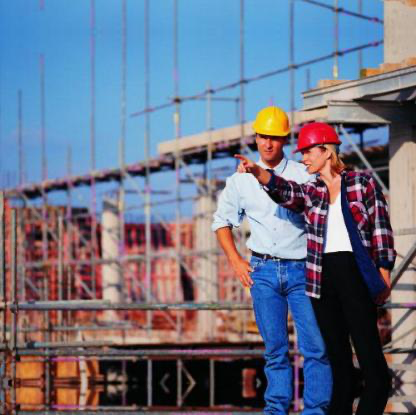

In [29]:
cv2_imshow(img)

In [31]:
for (classid, confidence, box) in zip(class_ids, confidences, boxes):
  roi = select_ROI(img, box)
  print("roi: ")
  cv2_imshow(roi)
  color = most_dominant_color(roi)
  cv2.rectangle(img, box, color, 2)
  cv2.rectangle(img, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)
  cv2.putText(img, classes[classid] + ' ' + str(int(confidence*100)) + '%', (box[0], box[1] - 10), cv2.FONT_HERSHEY_DUPLEX, 0.3, (0,0,0))
  

roi: 


roi: 


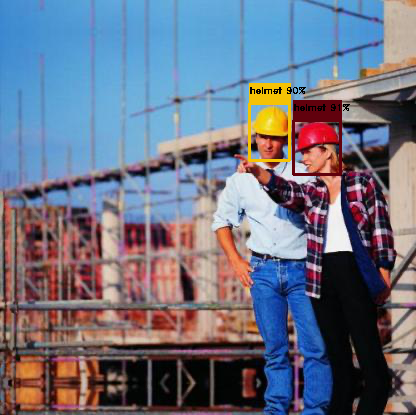

In [32]:
cv2_imshow(img)